In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import spacy
import numpy as np
from collections import defaultdict
from itertools import combinations, product
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import networkx as nx

from d3blocks import D3Blocks
from variables import PROJECTNAME_DATA_PATHS, SDG_MAP, ALL_EVAL_RESULTS_PATH
from file_org import iterdatatype_data

# Evaluate SDG balance & compare to model performance

| SDG | Data name       | Data name         |
| --- | --------------- | ----------------- |
|     | Test grad dsc   | Test ugrd outline |
|     | T / F           | T / F             |
| 1   | 5 (%) / 100 (%) | 40 (%) / 300 (%)  |


In [18]:
def count_sdgs(data):
    sdg_counts = {k: 0 for k in SDG_MAP.keys()}
    total_rows = data.shape[0]

    for label_data in data["labels"]:
        for label in set(label_data):
            sdg_counts[label] += 1

    return sdg_counts, total_rows


all_results = []
for datatype in PROJECTNAME_DATA_PATHS.keys():
    for project_name, data in iterdatatype_data(datatype):
        sdg_counts, total_rows = count_sdgs(data)
        for sdg, sdg_count in sdg_counts.items():
            all_results.append(
                dict(
                    project_name=project_name,
                    sdg=sdg,
                    datatype=datatype,
                    total_rows=total_rows,
                    positive=sdg_count,
                    negative=total_rows - sdg_count,
                    pos_perc=sdg_count / total_rows,
                    neg_perc=(total_rows - sdg_count) / total_rows,
                )
            )

data_counts_df = pd.DataFrame(all_results)

model_performance = pd.read_json(ALL_EVAL_RESULTS_PATH, orient="records", lines=True)
data_counts_df = data_counts_df.merge(
    model_performance, how="left", on=["sdg", "project_name"]
)

data_counts_df.to_excel("../data/exploratory/data_distribution.xlsx", index=False)
data_counts_df

,project_name,sdg,datatype_x,total_rows,positive,negative,pos_perc,neg_perc,model_name,datatype_y,precision,recall,f1,TP,FP,TN,FN
0,grad_desc,SDG 1,raw,1148,7,1141,0.006098,0.993902,logistic_regression,test,NaN,0.000000,NaN,0.0,0.0,229.0,1.0
1,grad_desc,SDG 1,raw,1148,7,1141,0.006098,0.993902,uoft_dict_approach,test,1.000000,1.000000,1.000000,1.0,0.0,229.0,0.0
2,grad_desc,SDG 2,raw,1148,2,1146,0.001742,0.998258,logistic_regression,test,NaN,NaN,NaN,0.0,0.0,230.0,0.0
3,grad_desc,SDG 2,raw,1148,2,1146,0.001742,0.998258,uoft_dict_approach,test,0.000000,NaN,NaN,0.0,3.0,227.0,0.0
4,grad_desc,SDG 3,raw,1148,180,968,0.156794,0.843206,logistic_regression,test,0.842105,0.533333,0.653061,16.0,3.0,197.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,undergrad_outlines,SDG 12,dev,96,3,93,0.031250,0.968750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,undergrad_outlines,SDG 13,dev,96,1,95,0.010417,0.989583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,undergrad_outlines,SDG 14,dev,96,0,96,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,undergrad_outlines,SDG 15,dev,96,4,92,0.041667,0.958333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Load data


In [2]:
file_path = PROJECTNAME_DATA_PATHS["raw"]("2023_grad_desc")
df = pd.read_json(file_path, orient="records", lines=True)

In [3]:
df.iloc[0]

text                 BUSINESS A701 / Intermediate Financial Account...
STRM                                                              2229
FACULTY DESC                                School of Graduate Studies
DEPARTMENT                                   Faculty of Business (MBA)
CRSE CAREER                                                       GRAD
SSR COMPONENT                                                      LEC
CRSE_ID                                                         101593
COURSE CODE                                                   BUSADMIN
CATALOG NBR                                                       A701
CLASS SECTION                                                      C01
CLASS DESCR                                          Interm.Finc.Acct1
ENROLMENT                                                            7
LAST TERM OFFERED                                            FALL 2022
URL                  https://academiccalendars.romcmaster.ca/previe...
cats  

# Get Feature Weights for Each SDG


In [4]:
nlp = spacy.load("en_core_web_lg")


def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])


def plot_coefficients(data, sdg):
    # Step 1: Tokenization and Preprocessing
    texts, labels = zip(*data)
    lemmatized_texts = [lemmatize_text(text) for text in texts]
    vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1, 3))
    X = vectorizer.fit_transform(lemmatized_texts)

    # Step 2: Train a Logistic Regression model
    model = LogisticRegression()
    model.fit(X, labels)

    # Step 3: Extract Feature Importance
    feature_names = vectorizer.get_feature_names_out()
    coef = model.coef_[0]

    # Step 4: Plot Coefficients
    sorted_indices = np.argsort(coef)
    top_indices = sorted_indices[-10:]  # Plotting top 10 terms for better visibility

    plt.barh(range(len(top_indices)), coef[top_indices])
    plt.yticks(range(len(top_indices)), [feature_names[i] for i in top_indices])
    plt.xlabel("Coefficient Value")
    plt.title(f"Top Coefficients for {sdg}")
    plt.show()

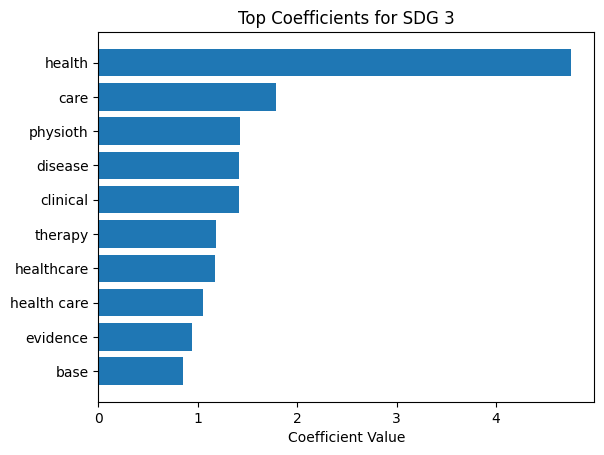

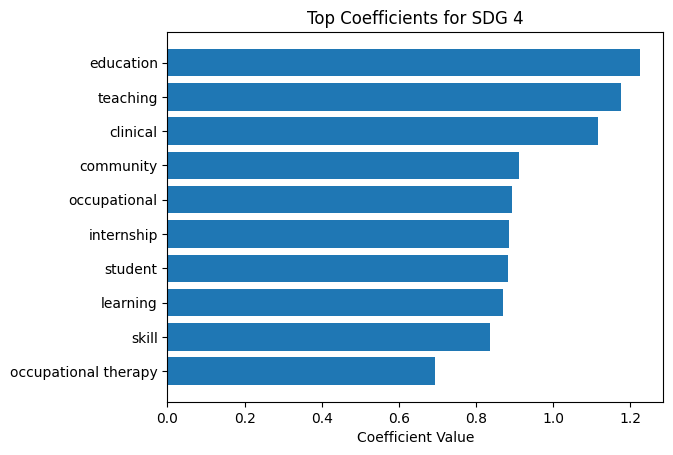

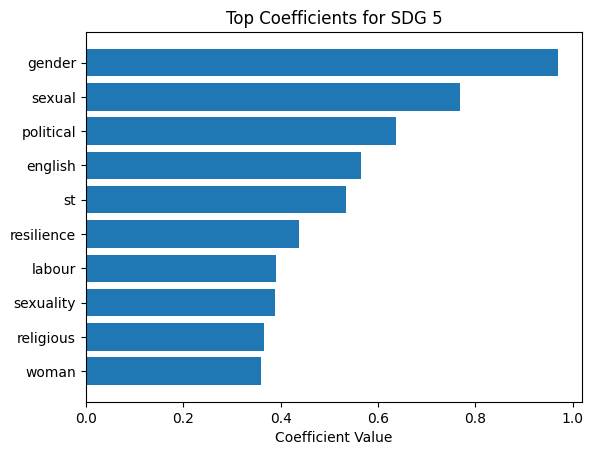

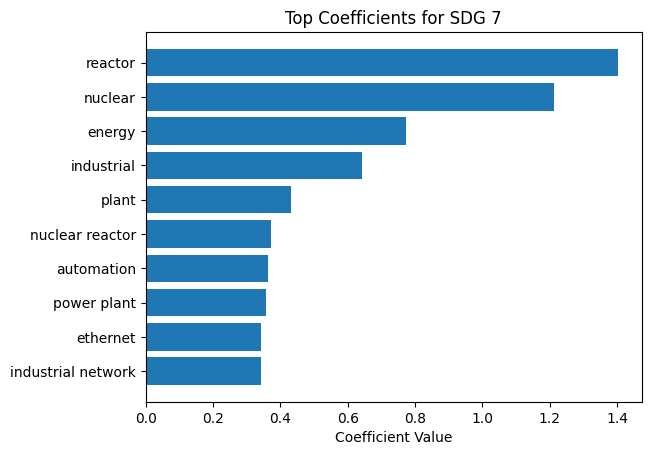

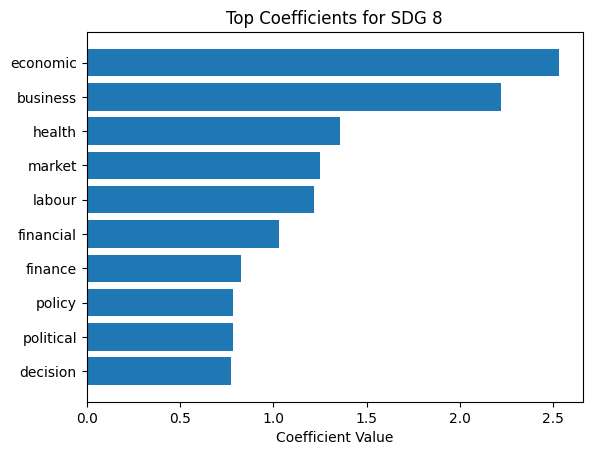

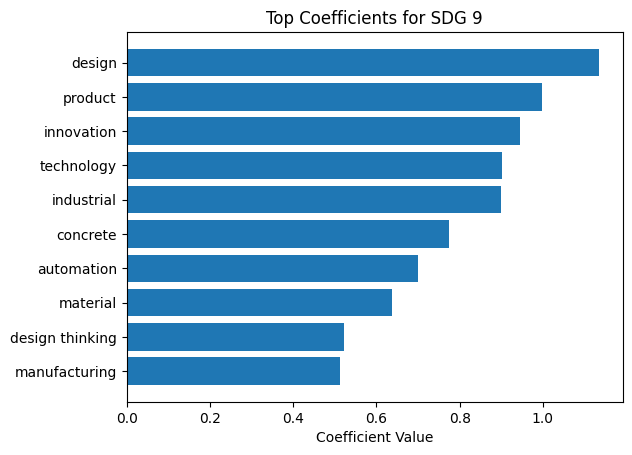

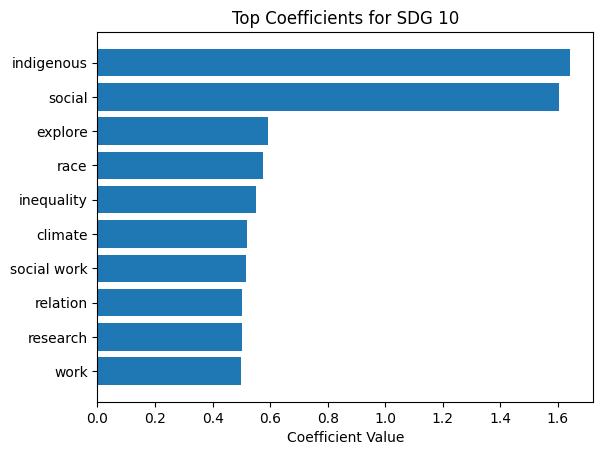

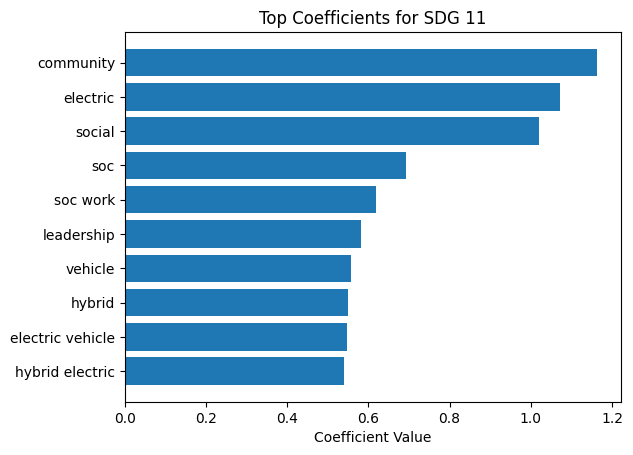

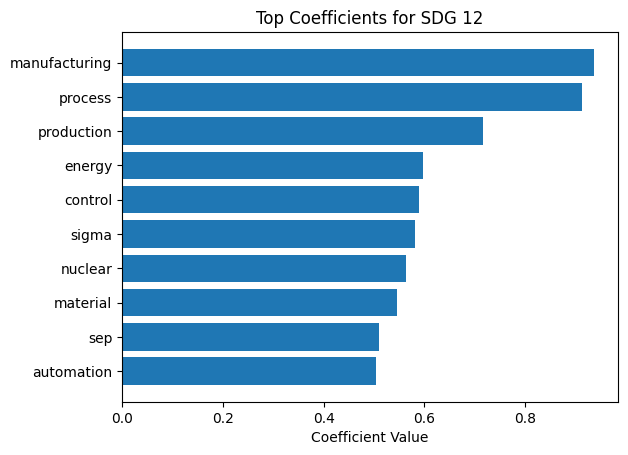

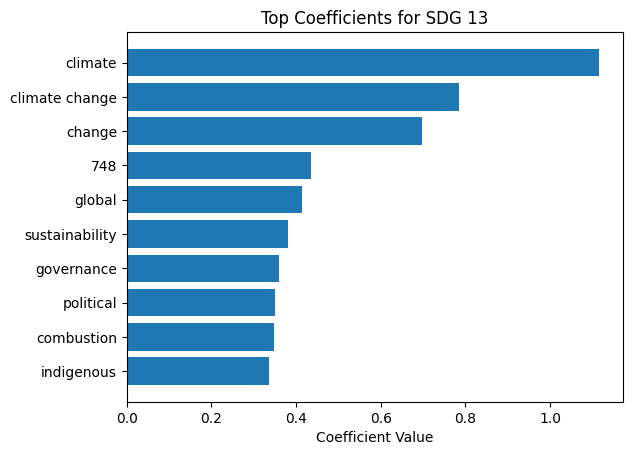

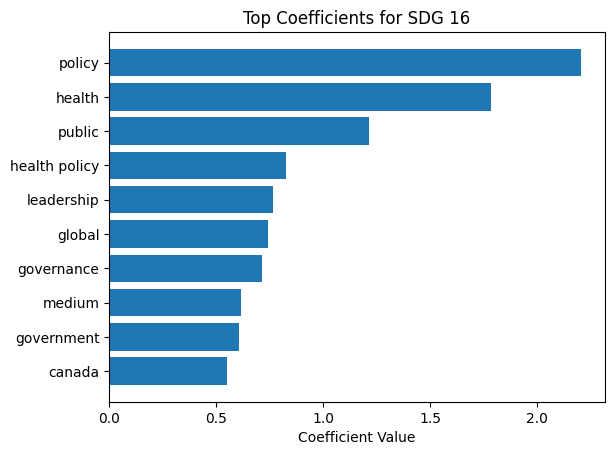

In [5]:
for i in range(1, 17):
    sdg = f"SDG {i}"
    labels = df["labels"].apply(lambda x: sdg in x)
    if sum(labels) < 10:
        continue
    plot_coefficients(zip(df["text"], labels), sdg)

# SDG Co-occurrence


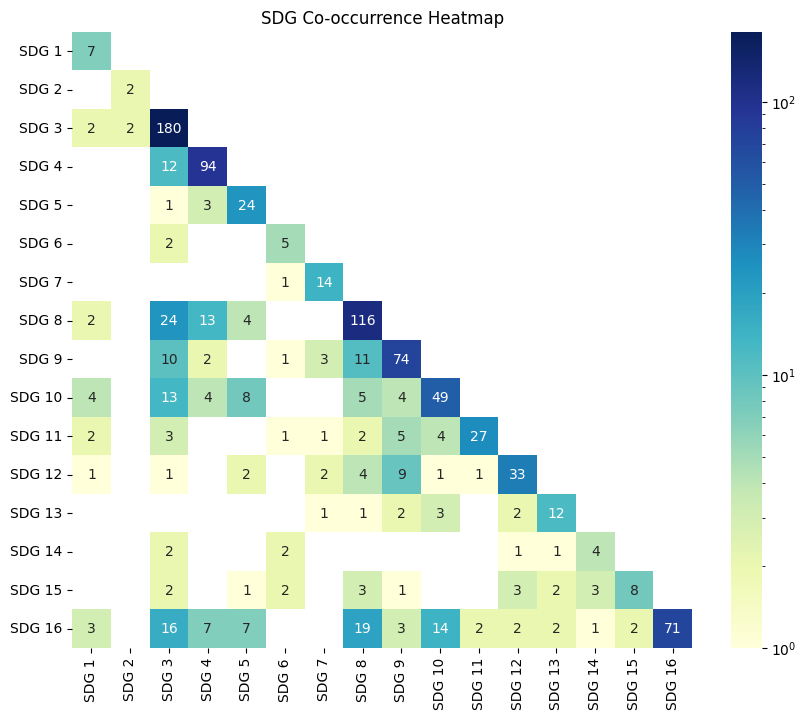

In [6]:
def create_cooccurrence_heatmap(sdg_list):
    # Create a dictionary to store the co-occurrence counts
    cooccurrence_counts = defaultdict(int)
    for sdgs in sdg_list:
        for sdg_1, sdg_2 in product(sdgs, sdgs):
            cooccurrence_counts[(sdg_1, sdg_2)] += 1

    # Convert the co-occurrence counts dictionary to a DataFrame
    df = pd.DataFrame.from_dict(cooccurrence_counts, orient="index", columns=["Count"])
    df.reset_index(inplace=True)
    df.rename(columns={"index": "Pair"}, inplace=True)
    df["v1"], df["v2"] = df["Pair"].apply(lambda x: x[0]), df["Pair"].apply(
        lambda x: x[1]
    )

    # Create a pivot table to reshape the data for the heatmap
    pivot_table = df.pivot(
        index="v1",
        columns="v2",
        values="Count",
    ).fillna(0)

    order = [f"SDG {i}" for i in range(1, 17)]
    pivot_table = pivot_table.loc[order, order]

    mask = np.triu(np.ones_like(pivot_table, dtype=bool), k=1)

    pivot_table = pivot_table.astype(int)

    # Create the heatmap using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        pivot_table, annot=True, cmap="YlGnBu", norm=LogNorm(), fmt="d", mask=mask
    )
    plt.title("SDG Co-occurrence Heatmap")
    plt.xlabel("")
    plt.ylabel("")
    plt.show()

    return df


cc_df = create_cooccurrence_heatmap(df["labels"])

In [7]:
def get_cc_df(sdg_list):
    # Create a dictionary to store the co-occurrence counts
    cooccurrence_counts = defaultdict(int)
    for sdgs in sdg_list:
        for sdg_1, sdg_2 in combinations(sdgs, 2):
            cooccurrence_counts[(sdg_1, sdg_2)] += 1

    # Convert the co-occurrence counts dictionary to a DataFrame
    df = pd.DataFrame.from_dict(cooccurrence_counts, orient="index", columns=["weight"])
    df.reset_index(inplace=True)
    df.rename(columns={"index": "Pair"}, inplace=True)
    df["source"], df["target"] = df["Pair"].apply(lambda x: x[0]), df["Pair"].apply(
        lambda x: x[1]
    )
    color_map = {
        "SDG 1": "#e5233d",
        "SDG 2": "#dda73a",
        "SDG 3": "#4ca146",
        "SDG 4": "#c5192d",
        "SDG 5": "#ef402c",
        "SDG 6": "#27bfe6",
        "SDG 7": "#fbc412",
        "SDG 8": "#a31c44",
        "SDG 9": "#f26a2d",
        "SDG 10": "#e01483",
        "SDG 11": "#f89d2a",
        "SDG 12": "#bf8d2c",
        "SDG 13": "#407f46",
        "SDG 14": "#1f97d4",
        "SDG 15": "#59ba48",
        "SDG 16": "#126a9f",
    }

    df["color"] = df["source"].apply(lambda s: color_map[s])

    return df


cc_df = get_cc_df(df["labels"])

In [8]:
cc_df

,Pair,weight,source,target,color
0,"(SDG 9, SDG 8)",4,SDG 9,SDG 8,#f26a2d
1,"(SDG 3, SDG 8)",14,SDG 3,SDG 8,#4ca146
2,"(SDG 3, SDG 16)",8,SDG 3,SDG 16,#4ca146
3,"(SDG 16, SDG 8)",19,SDG 16,SDG 8,#126a9f
4,"(SDG 3, SDG 2)",2,SDG 3,SDG 2,#4ca146
...,...,...,...,...,...
73,"(SDG 8, SDG 11)",2,SDG 8,SDG 11,#a31c44
74,"(SDG 16, SDG 11)",2,SDG 16,SDG 11,#126a9f
75,"(SDG 3, SDG 1)",2,SDG 3,SDG 1,#4ca146
76,"(SDG 10, SDG 1)",2,SDG 10,SDG 1,#e01483


In [9]:
d3 = D3Blocks()

# Plot
d3.chord(cc_df, color="source", notebook=True)

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [C:\Users\arman\AppData\Local\Temp\d3blocks\chord.html]
[d3blocks] >INFO> Convert to DataFrame.
[d3blocks] >INFO> Node properties are set.
c:\Users\arman\.virtualenvs\absa_set-CiDgubTM\Lib\site-packages\d3blocks\utils.py:604: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if 'weight' in X.columns: X['weight'] = X['weight'].astype(float)
[d3blocks] >INFO> Set edge-opacity based on the [source] node-opacity.
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File alr